In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [77]:
# basepath_feat = '../data/PBE/szp/basis_long_elf.json_processed/'
# basepath_tar = '../data/PBE/szp/'
# revpath_tar = '../data/MB-pol'

basepath_feat = '../data/BH/dz_custom_padded/basis_nocore_elf.json_processed/'
basepath_tar = '../data/BH/dz_custom_padded/'
revpath_tar = '../data/MB-pol/'

# systems = ['monomers','dimers','trimers']
systems = ['16p16']
mono_offset = 0
n_mol = [3,2,1]
# filters = [([True,True] + [False]*10)*3000]

for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
filters = np.genfromtxt('../data/BH/dz_custom_padded/filter.idx', dtype =bool)
filters = np.array([filters, filters]).T.flatten()
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[filters], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'h')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
(16384, 8)


In [66]:
old_scaler = nn.scaler

In [67]:
nn.load_all('../../elf_models/mlcf_master/16p16/pbedz_mbp_elf/')

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [68]:
nn.X_test = nn.scaler.transform(old_scaler.inverse_transform(nn.X_test))
nn.X_train = nn.scaler.transform(old_scaler.inverse_transform(nn.X_train))
nn.X_valid = nn.scaler.transform(old_scaler.inverse_transform(nn.X_valid))

ValueError: operands could not be broadcast together with shapes (1229,5) (6,) (1229,5) 

In [60]:
# nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp_long/force_o')

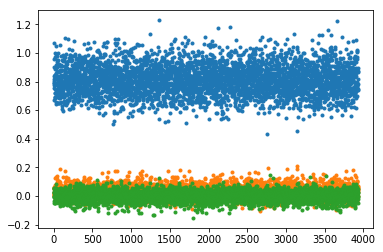

In [78]:
plot(nn.y_train,ls = '', marker = '.')


In [42]:
# learning_curve = nn.learning_curve(steps=8)

In [79]:
nn.nodes_per_layer = 16

In [80]:
nn.train(early_stopping=True, b=1e-8,batch_size=500, restart = False)

--------Epoch = 0----------
Training loss || Validation loss
     0.850480 ||      0.849165
--------Epoch = 500----------
Training loss || Validation loss
     0.053843 ||      0.054216
--------Epoch = 1000----------
Training loss || Validation loss
     0.052986 ||      0.053572
--------Epoch = 1500----------
Training loss || Validation loss
     0.052728 ||      0.053468
--------Epoch = 2000----------
Training loss || Validation loss
     0.052537 ||      0.053464
--------Epoch = 2500----------
Training loss || Validation loss
     0.052323 ||      0.053391


0

======== Evaluation on test set =============
              RMSE =  0.0503
              MAE = 0.0362
              Max. abs. error = 0.2957


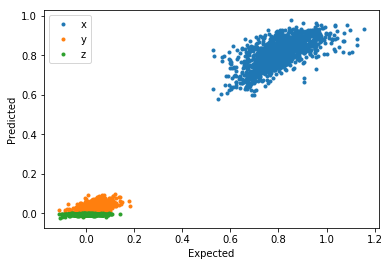

{'rmse': 0.05031633905684814,
 'mae': 0.03617726942386283,
 'max': 0.29565162250033084}

In [81]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.0723
              MAE = 0.0562
              Max. abs. error = 0.3088


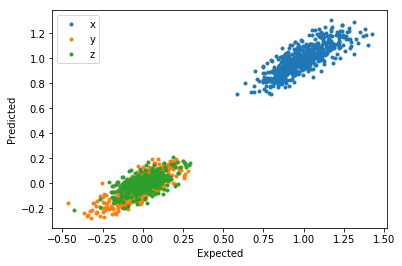

{'rmse': 0.07233807967861908,
 'mae': 0.056155483626236125,
 'max': 0.30876534024360963}

In [74]:
nn.evaluate(plot=True, on='test')

In [82]:
nn.save_all('../../elf_models/mlcf_master/16p16/bh_mbp_elf/', override=False)

In [54]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [57]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     0.690111 ||      0.689123
--------Epoch = 500----------
Training loss || Validation loss
     0.050323 ||      0.049841
--------Epoch = 1000----------
Training loss || Validation loss
     0.048252 ||      0.048288
--------Epoch = 1500----------
Training loss || Validation loss
     0.047829 ||      0.048089
--------Epoch = 2000----------
Training loss || Validation loss
     0.047680 ||      0.048073


KeyboardInterrupt: 

In [67]:
np.std(ensemble.std_predict(nn.X_test, processed=True), axis = 0)

array([0.00567823, 0.00177418, 0.00192366], dtype=float32)

In [2]:
mlcf.elf.utils.hdf5_to_elfs_fast('../data/PBE/dz_custom/basis_nocore_nn.json_processed/monomers_processed.hdf5')

{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


({'h': array([[[ 1.94163514e+02,  6.02683036e+00, -9.43041024e-16, ...,
           -1.27998820e+00, -1.26495199e-15, -3.55556318e+01],
          [ 1.94163514e+02,  6.02683036e+00,  6.28694016e-16, ...,
           -1.27998820e+00,  1.10995056e-15, -3.55556318e+01]],
  
         [[ 1.96259859e+02,  6.38298432e+00, -2.30121363e-16, ...,
           -1.46631669e+00,  2.03340878e-16, -3.47504477e+01],
          [ 1.96259859e+02,  6.38298432e+00,  5.58716798e-16, ...,
           -1.46631669e+00, -7.68639935e-17, -3.47504477e+01]],
  
         [[ 1.95590908e+02,  5.74872000e+00, -1.77173688e-18, ...,
           -1.02317855e+00,  2.96595568e-16, -3.45412571e+01],
          [ 1.95590908e+02,  5.74872000e+00,  3.62841917e-16, ...,
           -1.02317855e+00, -4.59882842e-16, -3.45412571e+01]],
  
         ...,
  
         [[ 2.00171650e+02,  4.35435680e+00,  4.59792631e-04, ...,
            3.24367034e-01, -1.67600337e-03, -3.23141951e+01],
          [ 2.18576748e+02,  4.31604621e+00, -9.08855264

In [3]:
force_model = {spec : mlcf.ml.load_force_model('../../elf_models/mlcf_master/16p16/pbedz_mbp/',spec)\
               for spec in ['o','h']}

predictions = {}
for spec in force_model:
    predictions[spec] = \
    force_model[spec].predict_from_hdf5('../data/PBE/dz_custom/basis_nocore_nn.json_processed/err_corr_processed.hdf5')


predictions['o'].reshape

predictions = np.concatenate([predictions['o'], predictions['h'].reshape(*predictions['o'].shape[:2],6)],
                            axis = -1)

predictions = predictions.reshape(*predictions.shape[:2],3,3)

{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


In [5]:
pbe = np.genfromtxt('../data/PBE/dz_custom/err_corr.forces', delimiter = ',').reshape(-1,128,3,3)
mbp = np.genfromtxt('../data/MB-pol/err_corr/err_corr.energies_forces').reshape(-1,128,3,3)
corrected = pbe + predictions


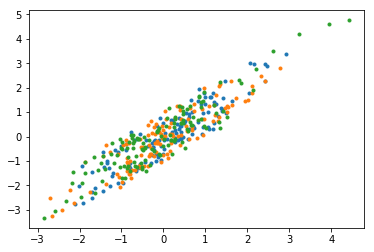

In [6]:
plot(mbp[0,:,0],pbe[0,:,0], ls = '' , marker = '.')

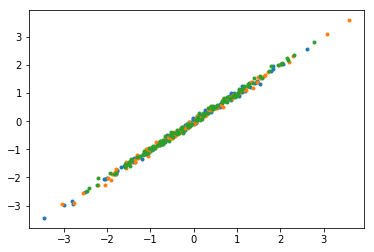

In [7]:
plot(mbp[1,:,0],corrected[1,:,0], ls = '', marker = '.')

In [8]:


[np.sum(np.sum(corrected[:i,:,:].reshape(-1,128,3), axis = 1), axis =0) for i in range(1,len(corrected))]

[array([ 0.48926848,  0.95216391, -1.06657994]),
 array([ 1.18438961,  1.24460718, -1.28257881]),
 array([ 1.18252973,  2.89547068, -1.94029544]),
 array([ 1.99195044,  3.86332466, -2.59345108]),
 array([ 2.32387379,  4.82236835, -2.72547033]),
 array([ 2.6515023 ,  5.66000309, -2.55049938]),
 array([ 3.57437998,  6.26657728, -3.11688983]),
 array([ 4.03209728,  7.27045905, -4.33360723]),
 array([ 4.31039953,  8.1941657 , -5.69126009]),
 array([ 5.15373181,  8.30528312, -6.09290566]),
 array([ 5.83082547,  8.4493193 , -6.89510968]),
 array([ 5.92637633,  8.80695834, -7.45145461]),
 array([ 6.61459123,  8.96529522, -8.60952217]),
 array([ 7.07202161,  9.03044731, -9.72286761]),
 array([  7.63997674,   9.03903294, -10.52682919]),
 array([  8.32690146,   9.2119155 , -11.77081462]),
 array([  8.06053008,   8.91757893, -12.61162165]),
 array([  7.65289831,   9.00842129, -13.59631137]),
 array([  7.68656376,   9.54141468, -14.635822  ]),
 array([  8.25413051,   9.87615036, -15.24380781]),
 a